In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

In [4]:
import openml
# mammography dataset https://www.openml.org/d/310
data = openml.datasets.get_dataset(310)
X, y = data.get_data(target=data.default_target_attribute)

In [5]:
data.default_target_attribute

'class'

In [6]:
X.shape

(11183, 6)

In [7]:
np.bincount(y)

array([10923,   260])

In [8]:
df = pd.DataFrame(X)

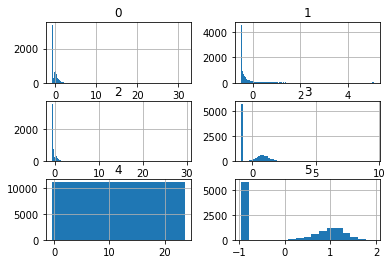

In [9]:
df.hist(bins='auto');

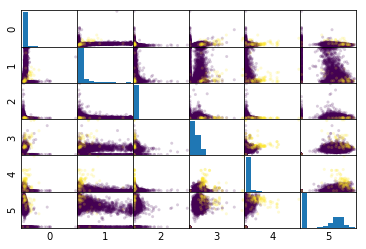

In [10]:
axes = pd.plotting.scatter_matrix(df, c=y, alpha=.2);
for ax in axes.ravel():
    ax.set_xticks(())
    ax.set_yticks(())
plt.savefig('images/mammography_data.png')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Quick PCA visualization (not used later)

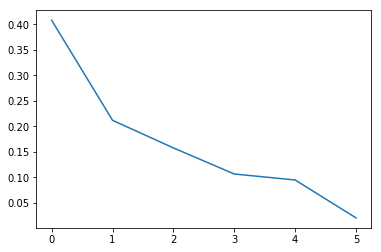

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)

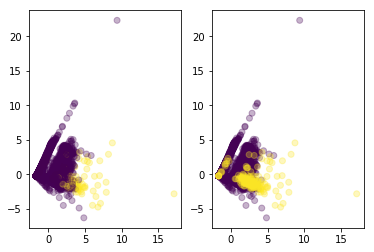

In [15]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca[sorting, 0], X_train_pca[sorting, 1], c=y_train[sorting], alpha=.3)

In [16]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler().fit(X_train)
X_train_scaled = rs.transform(X_train)

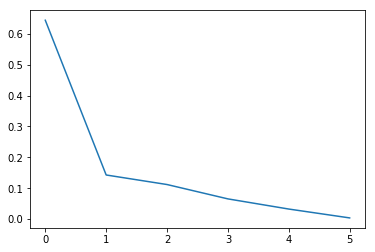

In [17]:
pca_scaled = PCA()
X_train_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
plt.plot(pca_scaled.explained_variance_ratio_)

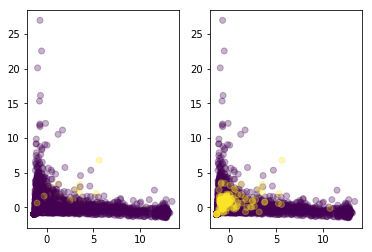

In [18]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca_scaled[sorting, 0], X_train_pca_scaled[sorting, 1], c=y_train[sorting], alpha=.3)

## Back to original data

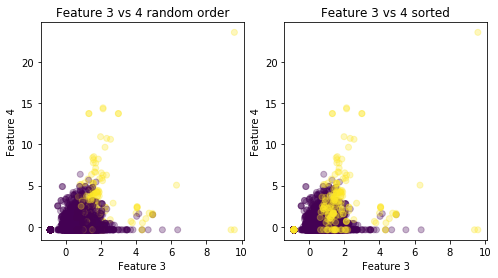

In [23]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3)
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[0].set_title("Feature 3 vs 4 random order")
axes[1].set_title("Feature 3 vs 4 sorted")
for ax in axes:
    ax.set_xlabel("Feature 3")
    ax.set_ylabel("Feature 4")
plt.savefig("images/mammography_features23.png")

In [93]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(),
                         X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean(), 

In [97]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                         X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean(), 

(0.94577922311250295, 0.72696614060380282)

In [27]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [28]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.916994388919


In [88]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.548470855138


In [29]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [89]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.915807189761


In [ ]:
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

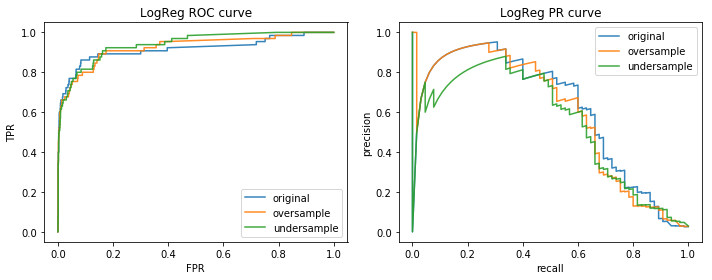

In [46]:
from sklearn.metrics import roc_curve, precision_recall_curve
oversample_pipe.fit(X_train, y_train)
probs_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe.fit(X_train, y_train)
probs_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

lr = LogisticRegression().fit(X_train, y_train)
probs_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("LogReg ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("LogReg PR curve")
plt.tight_layout()
plt.savefig("images/curves_logreg.png")

In [33]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.942806918798


In [34]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100),
                         X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.722975517678


In [35]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(undersample_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.952451813359


In [36]:
scores = cross_val_score(undersample_pipe_rf, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.594813159774


In [37]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(oversample_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.927853611907


In [38]:
scores = cross_val_score(oversample_pipe_rf, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.712283845713


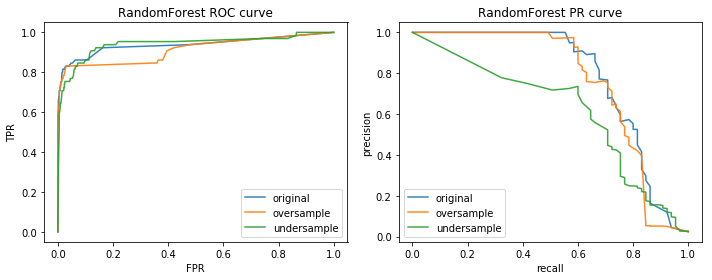

In [47]:
from sklearn.metrics import roc_curve
oversample_pipe_rf.fit(X_train, y_train)
probs_oversample = oversample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe_rf.fit(X_train, y_train)
probs_undersample = undersample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
probs_original = rf.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("RandomForest ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()
plt.savefig("images/curves_rf.png")

# Class Weights

In [40]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.917567920152


In [48]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='average_precision')
print(scores.mean())

0.587460808383


In [41]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.919568893701


In [49]:
scores = cross_val_score(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.698148084124


# Resampled Ensembles

In [42]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
resampled_rf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                         n_estimators=100, random_state=0)

In [43]:
scores = cross_val_score(resampled_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.956012017027


In [44]:
scores = cross_val_score(resampled_rf, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.654914584228


In [50]:
resampled_lr = BalancedBaggingClassifier(LogisticRegression(),
                                         n_estimators=100, random_state=0)

scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.918198720496


In [51]:
scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.552289955736


In [52]:
from sklearn.metrics import roc_curve
oversample_pipe_rf.fit(X_train, y_train)
probs_oversample = oversample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe_rf.fit(X_train, y_train)
probs_undersample = undersample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

resampled_rf.fit(X_train, y_train)
probs_easy_ensemble = resampled_rf.predict_proba(X_test)[:, 1]
fpr_ee, tpr_ee, _ = roc_curve(y_test, probs_easy_ensemble)
precision_ee, recall_ee, _ = precision_recall_curve(y_test, probs_easy_ensemble)

rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
probs_original = rf.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

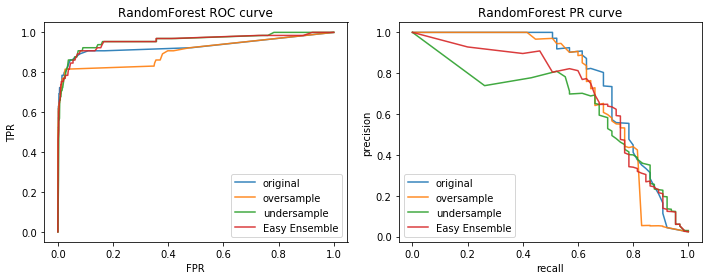

In [53]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].plot(fpr_ee, tpr_ee, label="Easy Ensemble", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("RandomForest ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].plot(recall_ee, precision_ee, label="Easy Ensemble", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()
plt.savefig("images/roc_vs_pr.png", dpi=500)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, undersample_pipe_rf.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      0.92      0.96      2731
          1       0.21      0.91      0.35        65

avg / total       0.98      0.92      0.94      2796



In [55]:
print(classification_report(y_test, oversample_pipe_rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2731
          1       0.87      0.62      0.72        65

avg / total       0.99      0.99      0.99      2796



In [56]:
print(classification_report(y_test, resampled_rf.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      0.93      0.96      2731
          1       0.24      0.88      0.38        65

avg / total       0.98      0.93      0.95      2796



# Edited Nearest Neighbors

In [57]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_sample(X_train, y_train)

enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(X_train, y_train)

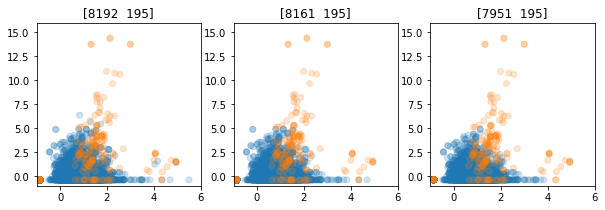

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
datasets = [(X_train, y_train), (X_train_enn_mode, y_train_enn_mode), (X_train_enn, y_train_enn)]
for ax, (X_, y_) in zip(axes, datasets):
    # make sure we plot the orange over the blue
    sorting = np.argsort(y_)
    ax.scatter(X_[sorting, 3], X_[sorting, 4], c=plt.cm.Vega10(y_[sorting]), alpha=.2)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 16)
    ax.set_title(np.bincount(y_))

In [60]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                             LogisticRegression())
scores = cross_val_score(enn_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.920155354576


In [61]:
scores = cross_val_score(enn_pipe, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.627325075315


In [63]:
enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                                RandomForestClassifier(n_estimators=100))
scores = cross_val_score(enn_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.940349121906


In [64]:
scores = cross_val_score(enn_pipe_rf, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.69377127477


In [65]:
from sklearn.model_selection import GridSearchCV
param_grid = {'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']}
search = GridSearchCV(enn_pipe, param_grid, cv=10, scoring="average_precision", return_train_score=True)
# search.fit(X_train, y_train)

/home/andy/checkout/scikit-learn/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('editednearestneighbours', EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=5,
            random_state=None, ratio='auto', return_indices=False,
            size_ngh=None)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None,...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [66]:
# results = pd.DataFrame(search.cv_results_)
# res_pivot = results.pivot_table(values=['mean_test_score', 'mean_train_score'],
#                               columns="param_editednearestneighbours__kind_sel",
#                                index="param_editednearestneighbours__n_neighbors")

Text(0.5,0,'n_neighbors')

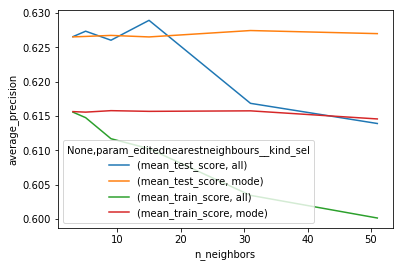

In [68]:
#res_pivot.plot()
#plt.ylabel("average_precision")
#plt.xlabel("n_neighbors")

In [69]:
#from sklearn.model_selection import GridSearchCV
#param_grid = {'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']}
#search = GridSearchCV(enn_pipe_rf, param_grid, cv=10, scoring="average_precision", return_train_score=True)
#search.fit(X_train, y_train)

/home/andy/checkout/scikit-learn/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('editednearestneighbours', EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=5,
            random_state=None, ratio='auto', return_indices=False,
            size_ngh=None)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
 ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'editednearestneighbours__n_neighbors': [3, 5, 9, 15, 31, 51], 'editednearestneighbours__kind_sel': ['mode', 'all']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='average_precision', verbose=0)

In [70]:
#results = pd.DataFrame(search.cv_results_)
#res_pivot = results.pivot_table(values=['mean_test_score', 'mean_train_score'],
#                                columns="param_editednearestneighbours__kind_sel",
#                                index="param_editednearestneighbours__n_neighbors")

In [71]:
# res_pivot.plot()

In [72]:
# search.best_score_

Text(0.5,1,'Condensed Nearest Neighbor')

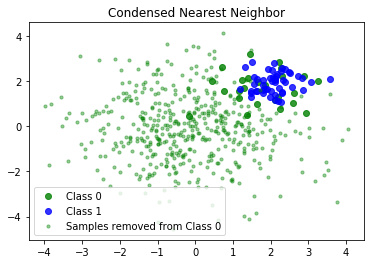

In [76]:
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.utils import shuffle

rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)


def plot_resampled(X_org, y_org, X_res, y_res, idx, ax=None):
    if ax is None:
        ax = plt.gca()
    idx_samples_removed = np.setdiff1d(np.arange(X_org.shape[0]),
                                       idx)
    idx_class_0 = y_res == 0
    ax.scatter(X_res[idx_class_0, 0], X_res[idx_class_0, 1],
                c='g', alpha=.8, label='Class 0')
    ax.scatter(X_res[~idx_class_0, 0], X_res[~idx_class_0, 1],
                c='b', alpha=.8, label='Class 1')
    ax.scatter(X_org[idx_samples_removed, 0], X_org[idx_samples_removed, 1],
                c='g', alpha=.4, s=10, label='Samples removed from Class 0')
    ax.legend()
    

cnn = CondensedNearestNeighbour(return_indices=True)
X_resampled, y_resampled, idx_resampled = cnn.fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled)
plt.title("Condensed Nearest Neighbor")

Text(0.5,1,'Edited Nearest Neighbor')

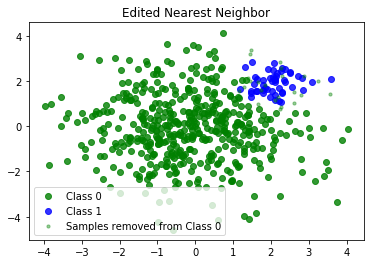

In [77]:
enn = EditedNearestNeighbours(return_indices=True)
X_resampled, y_resampled, idx_resampled = enn.fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled)
plt.title("Edited Nearest Neighbor")

Text(0.5,1,'Condensed Nearest Neighbor')

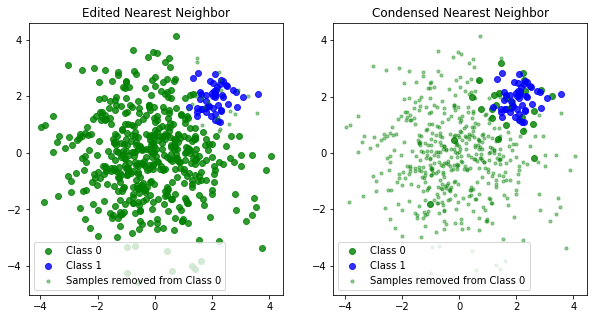

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
enn = EditedNearestNeighbours(return_indices=True)
X_resampled, y_resampled, idx_resampled = enn.fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled, ax=ax[0])
ax[0].set_title("Edited Nearest Neighbor")
X_resampled, y_resampled, idx_resampled = CondensedNearestNeighbour(return_indices=True).fit_sample(X_syn, y_syn)
plot_resampled(X_syn, y_syn, X_resampled, y_resampled, idx_resampled, ax=ax[1])
ax[1].set_title("Condensed Nearest Neighbor")

In [79]:
cnn = CondensedNearestNeighbour()
X_train_cnn, y_train_cnn = cnn.fit_sample(X_train, y_train)
print(X_train_cnn.shape)
print(np.bincount(y_train_cnn))

(557, 6)
[362 195]


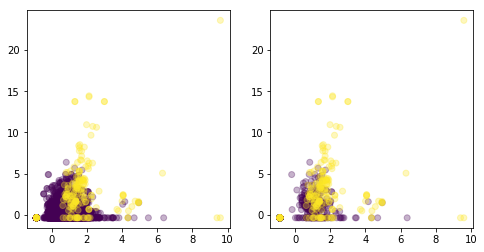

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sorting = np.argsort(y_train)
sorting_cnn = np.argsort(y_train_cnn)
axes[0].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[1].scatter(X_train_cnn[sorting_cnn, 3], X_train_cnn[sorting_cnn, 4], c=y_train_cnn[sorting_cnn], alpha=.3)

In [82]:
cnn_pipe = make_imb_pipeline(CondensedNearestNeighbour(), LogisticRegression())
scores = cross_val_score(cnn_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.919539873174


In [83]:
scores = cross_val_score(cnn_pipe, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.606906556135


In [84]:
cnn_pipe = make_imb_pipeline(CondensedNearestNeighbour(),
                               RandomForestClassifier(n_estimators=100))
scores = cross_val_score(cnn_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.951638527996


In [85]:
scores = cross_val_score(cnn_pipe, X_train, y_train, cv=10, scoring='average_precision')
print(np.mean(scores))

0.716303579099


# SMOTE

In [86]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(X_train_smote.shape)
print(np.bincount(y_train_smote))

(16384, 6)
[8192 8192]


Text(0.5,1,'SMOTE')

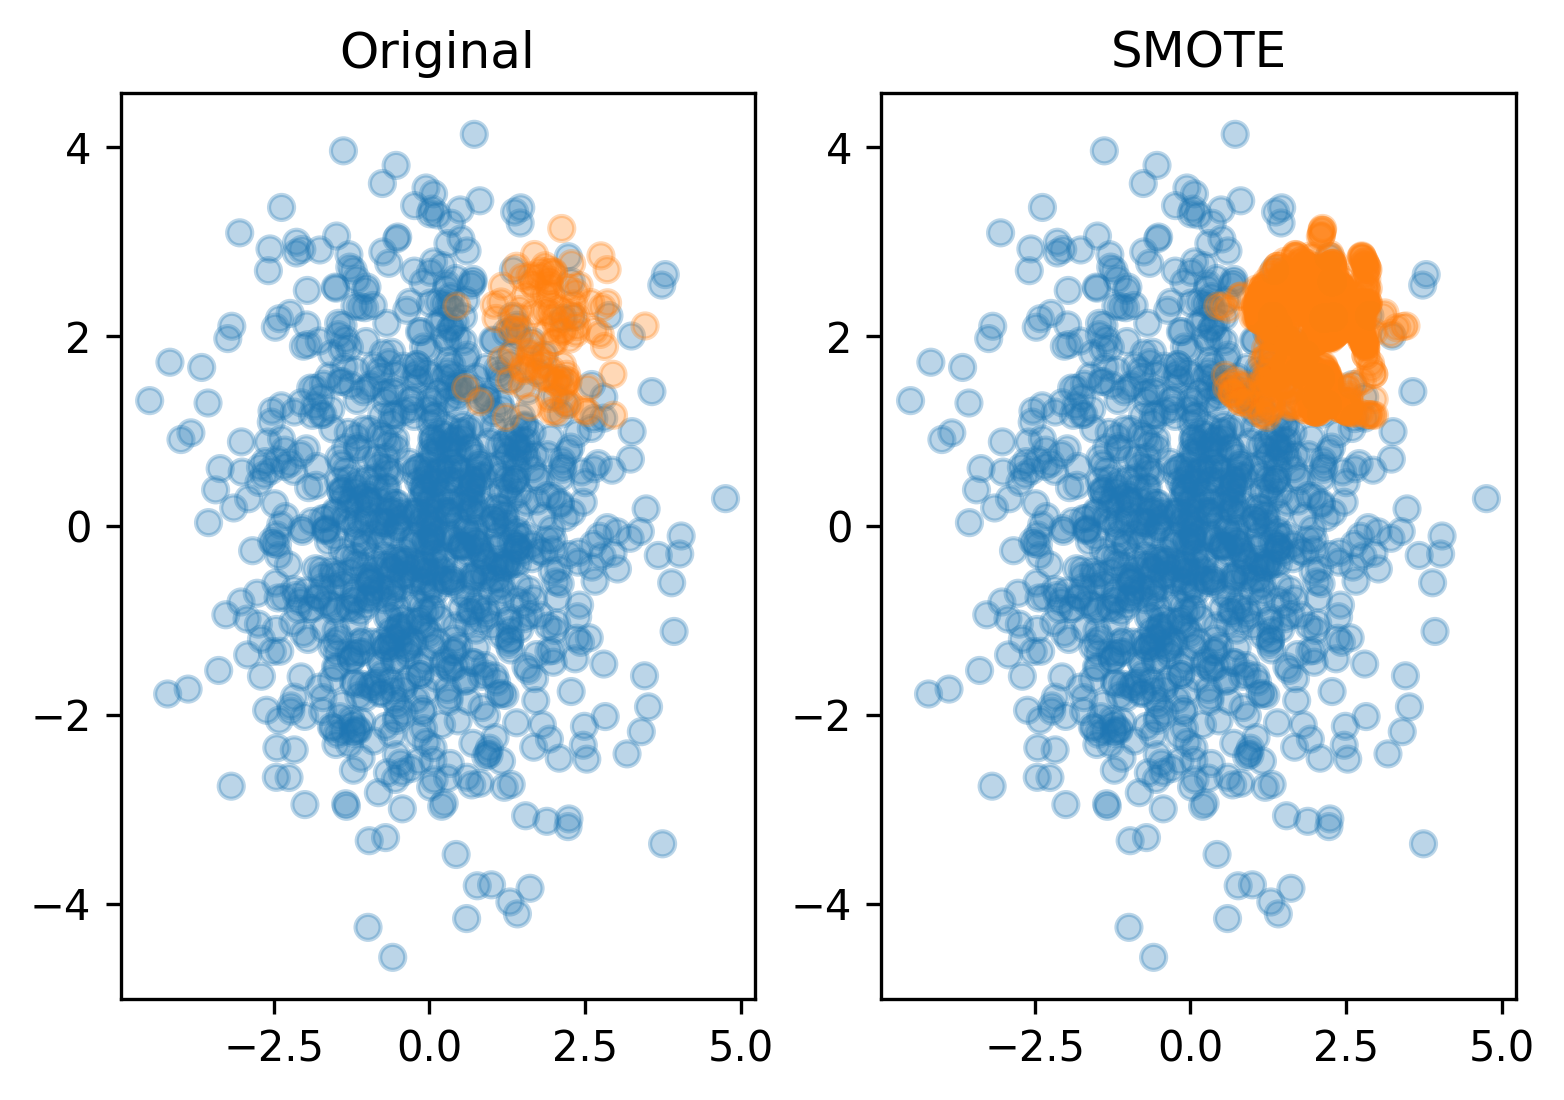

In [24]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
fig, axes = plt.subplots(1, 2, figsize=(8, 4), subplot_kw={'xticks':(), 'yticks':()})
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.Vega10(y_syn), alpha=.3)
axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.Vega10(y_resampled), alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")

Text(0.5,1,'SMOTE')

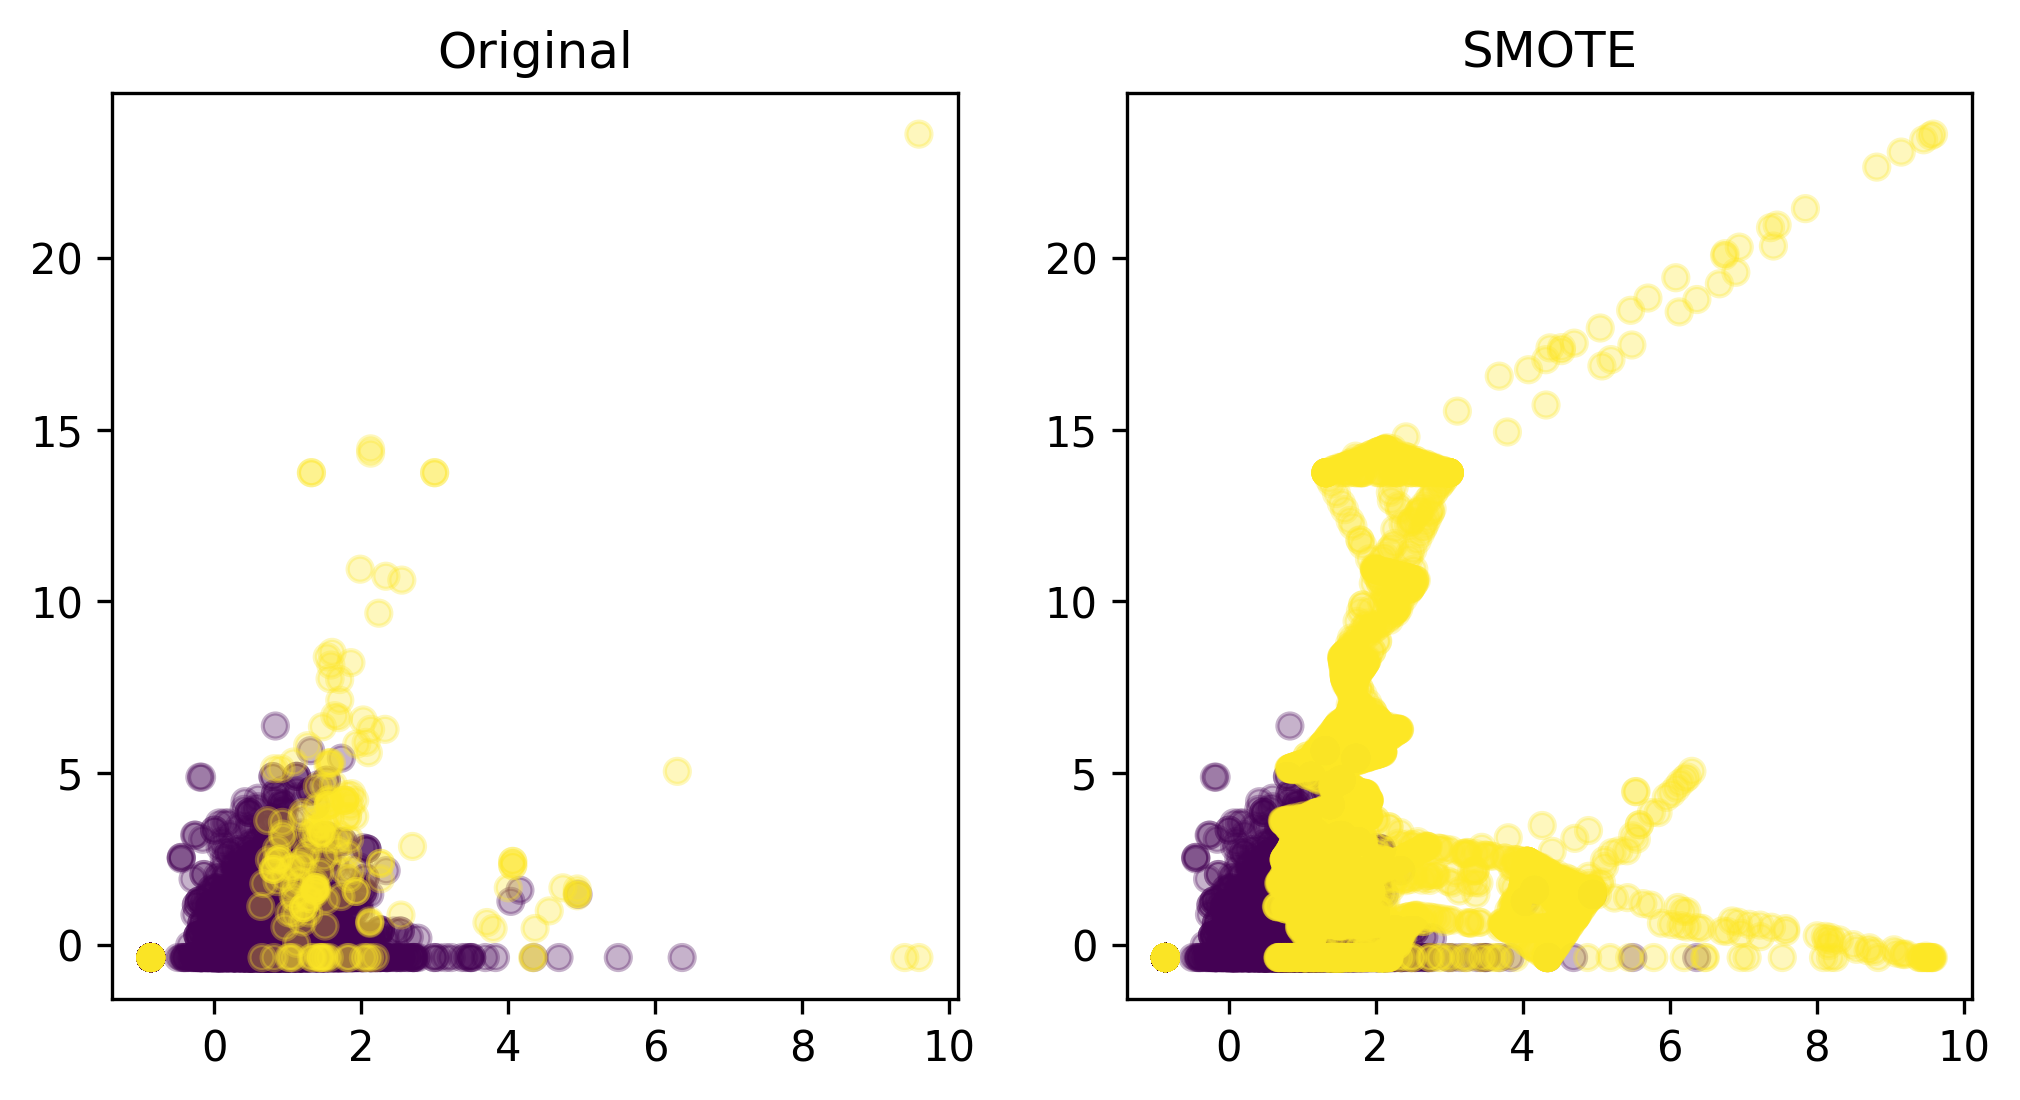

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sorting = np.argsort(y_train)
axes[0].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[1].scatter(X_train_smote[:, 3], X_train_smote[:, 4], c=y_train_smote, alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")

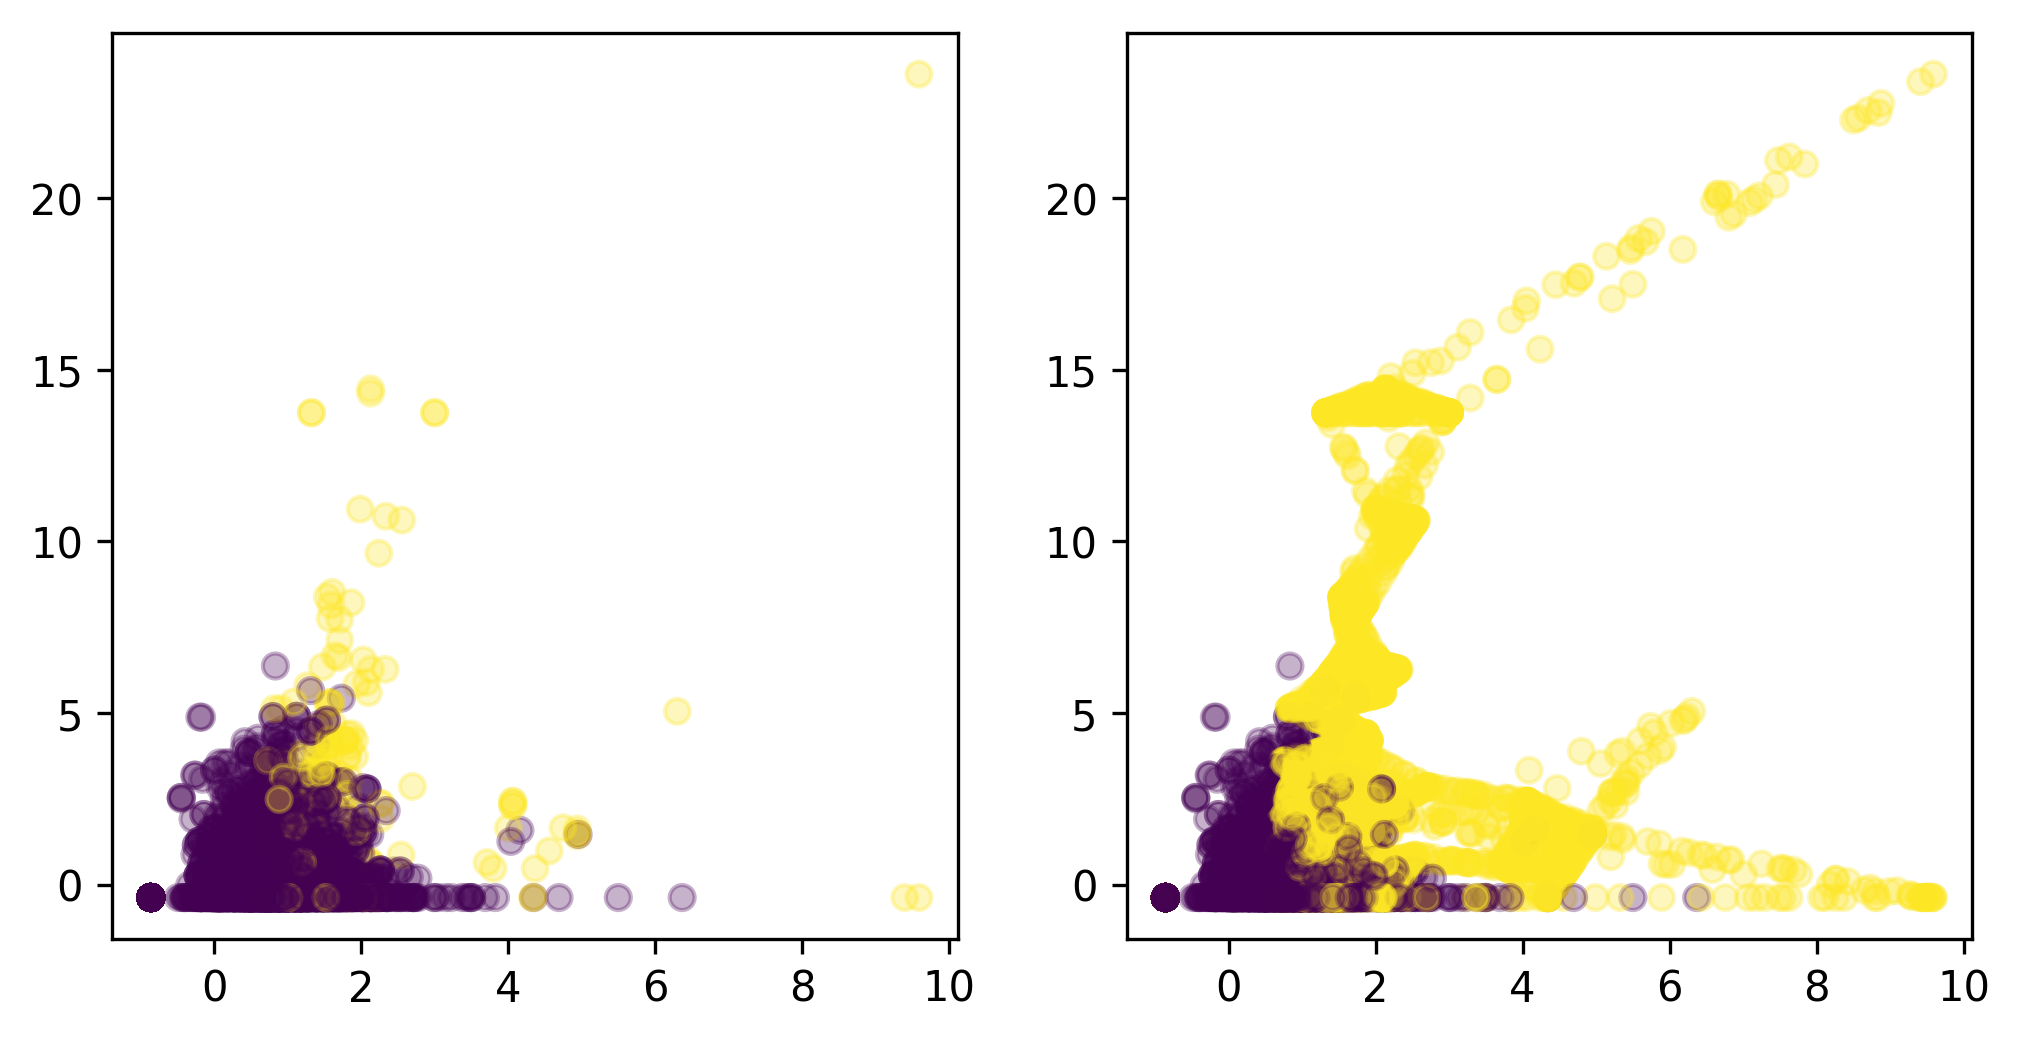

In [223]:
from sklearn.utils import shuffle
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh, y_smote_sh = shuffle(X_train_smote, y_train_smote)
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train, alpha=.3)
axes[1].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=y_smote_sh, alpha=.3)

In [148]:
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegression())
scores = cross_val_score(smote_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.918776908461


In [212]:
smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smote_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.94679634593


In [207]:
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, scoring="roc_auc")
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('smote', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=None, ratio='auto', svm_estimator=None)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, m...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [208]:
search.best_score_

0.95823089499095737

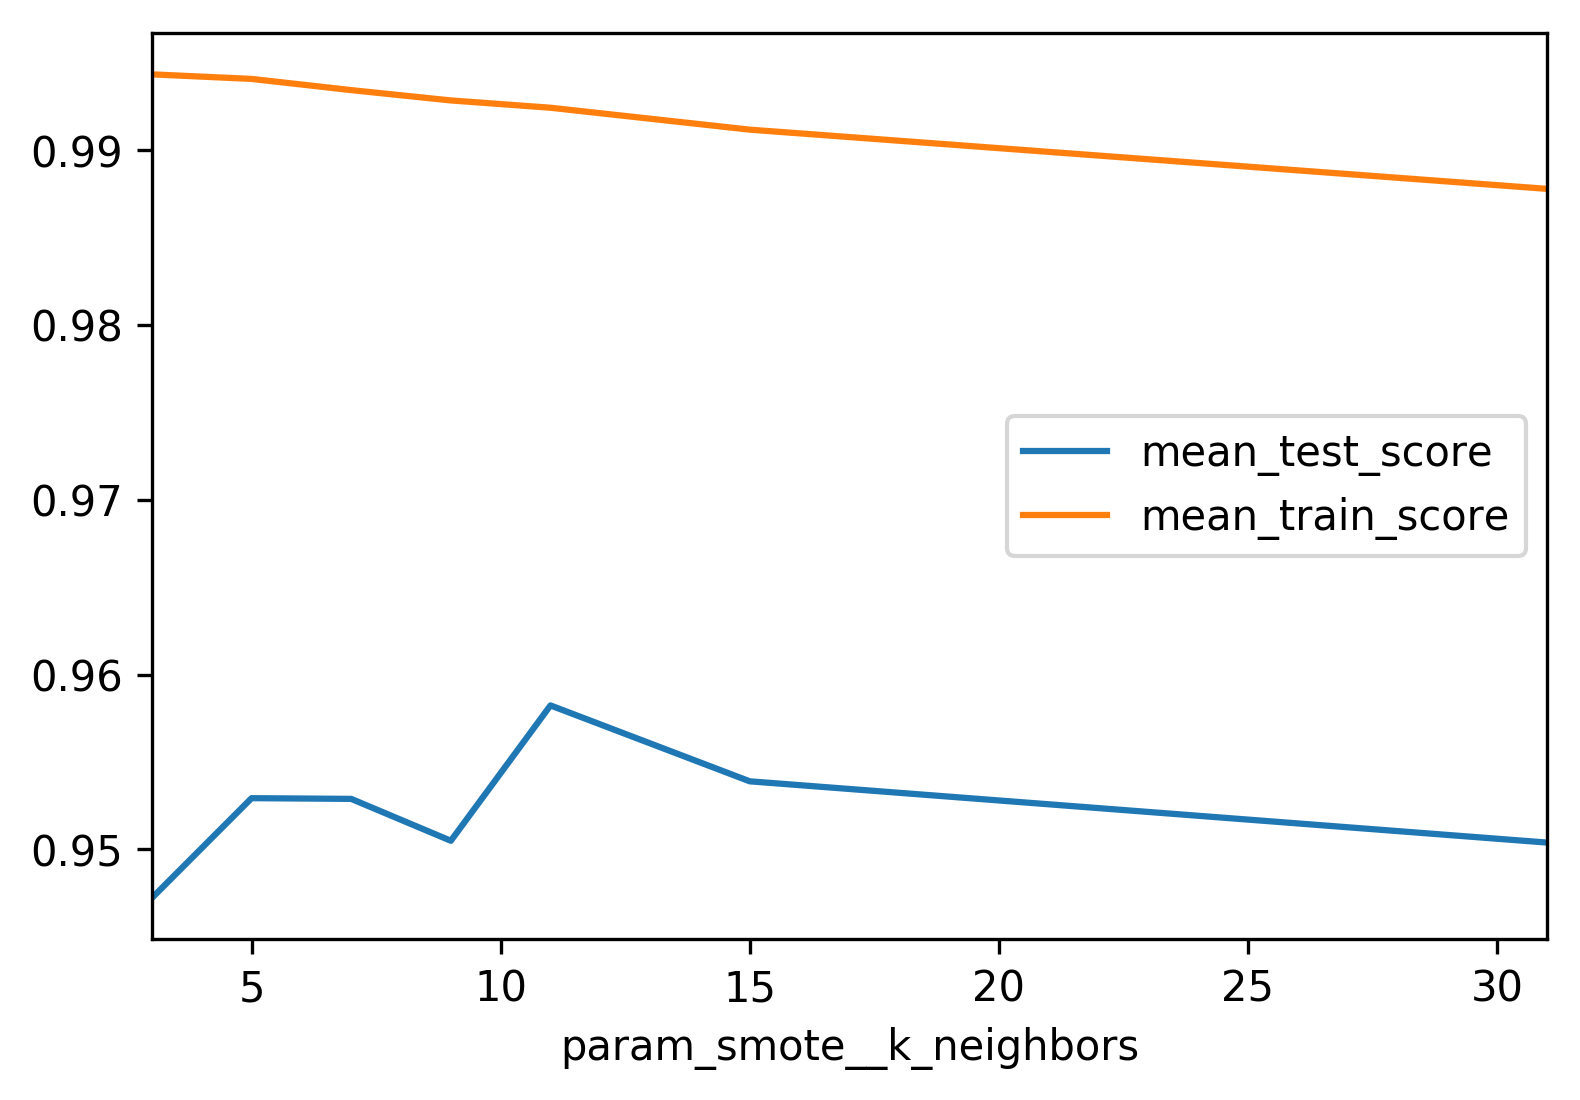

In [209]:
results = pd.DataFrame(search.cv_results_)
results.plot("param_smote__k_neighbors", ["mean_test_score", "mean_train_score"])
plt.ylabel("ROC AUC")

In [211]:
smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=11), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smote_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.956115242962


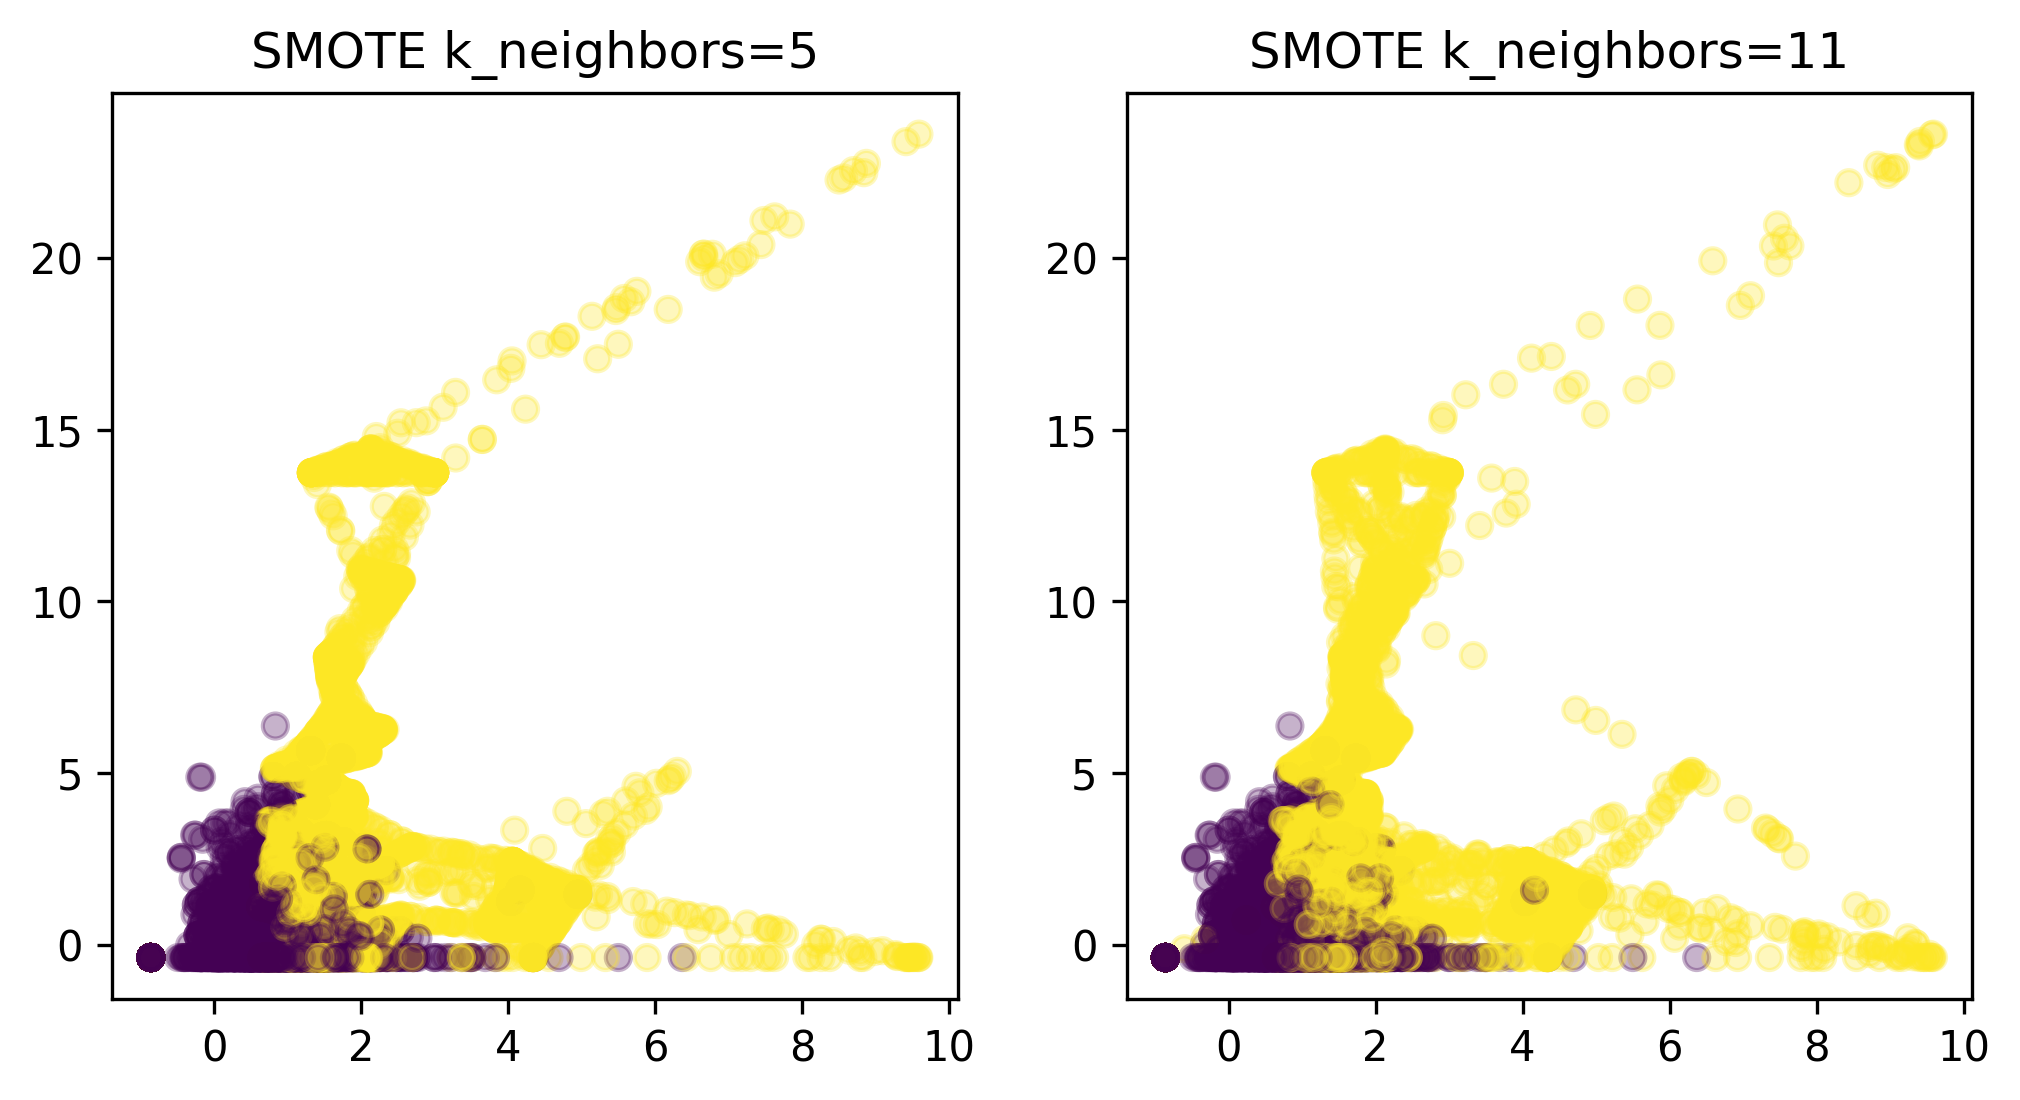

In [224]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=11)
X_train_smote11, y_train_smote11 = smote.fit_sample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh11, y_smote_sh11 = shuffle(X_train_smote11, y_train_smote11)
axes[0].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=y_smote_sh, alpha=.3)
axes[1].scatter(X_smote_sh11[:, 3], X_smote_sh11[:, 4], c=y_smote_sh11, alpha=.3)
axes[0].set_title("SMOTE k_neighbors=5")
axes[1].set_title("SMOTE k_neighbors=11")

In [214]:
from imblearn.combine import SMOTEENN, SMOTETomek
smoteenn_pipe_rf = make_imb_pipeline(SMOTEENN(smote=SMOTE(k_neighbors=11)), RandomForestClassifier(n_estimators=100))
scores = cross_val_score(smoteenn_pipe_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.953204388982


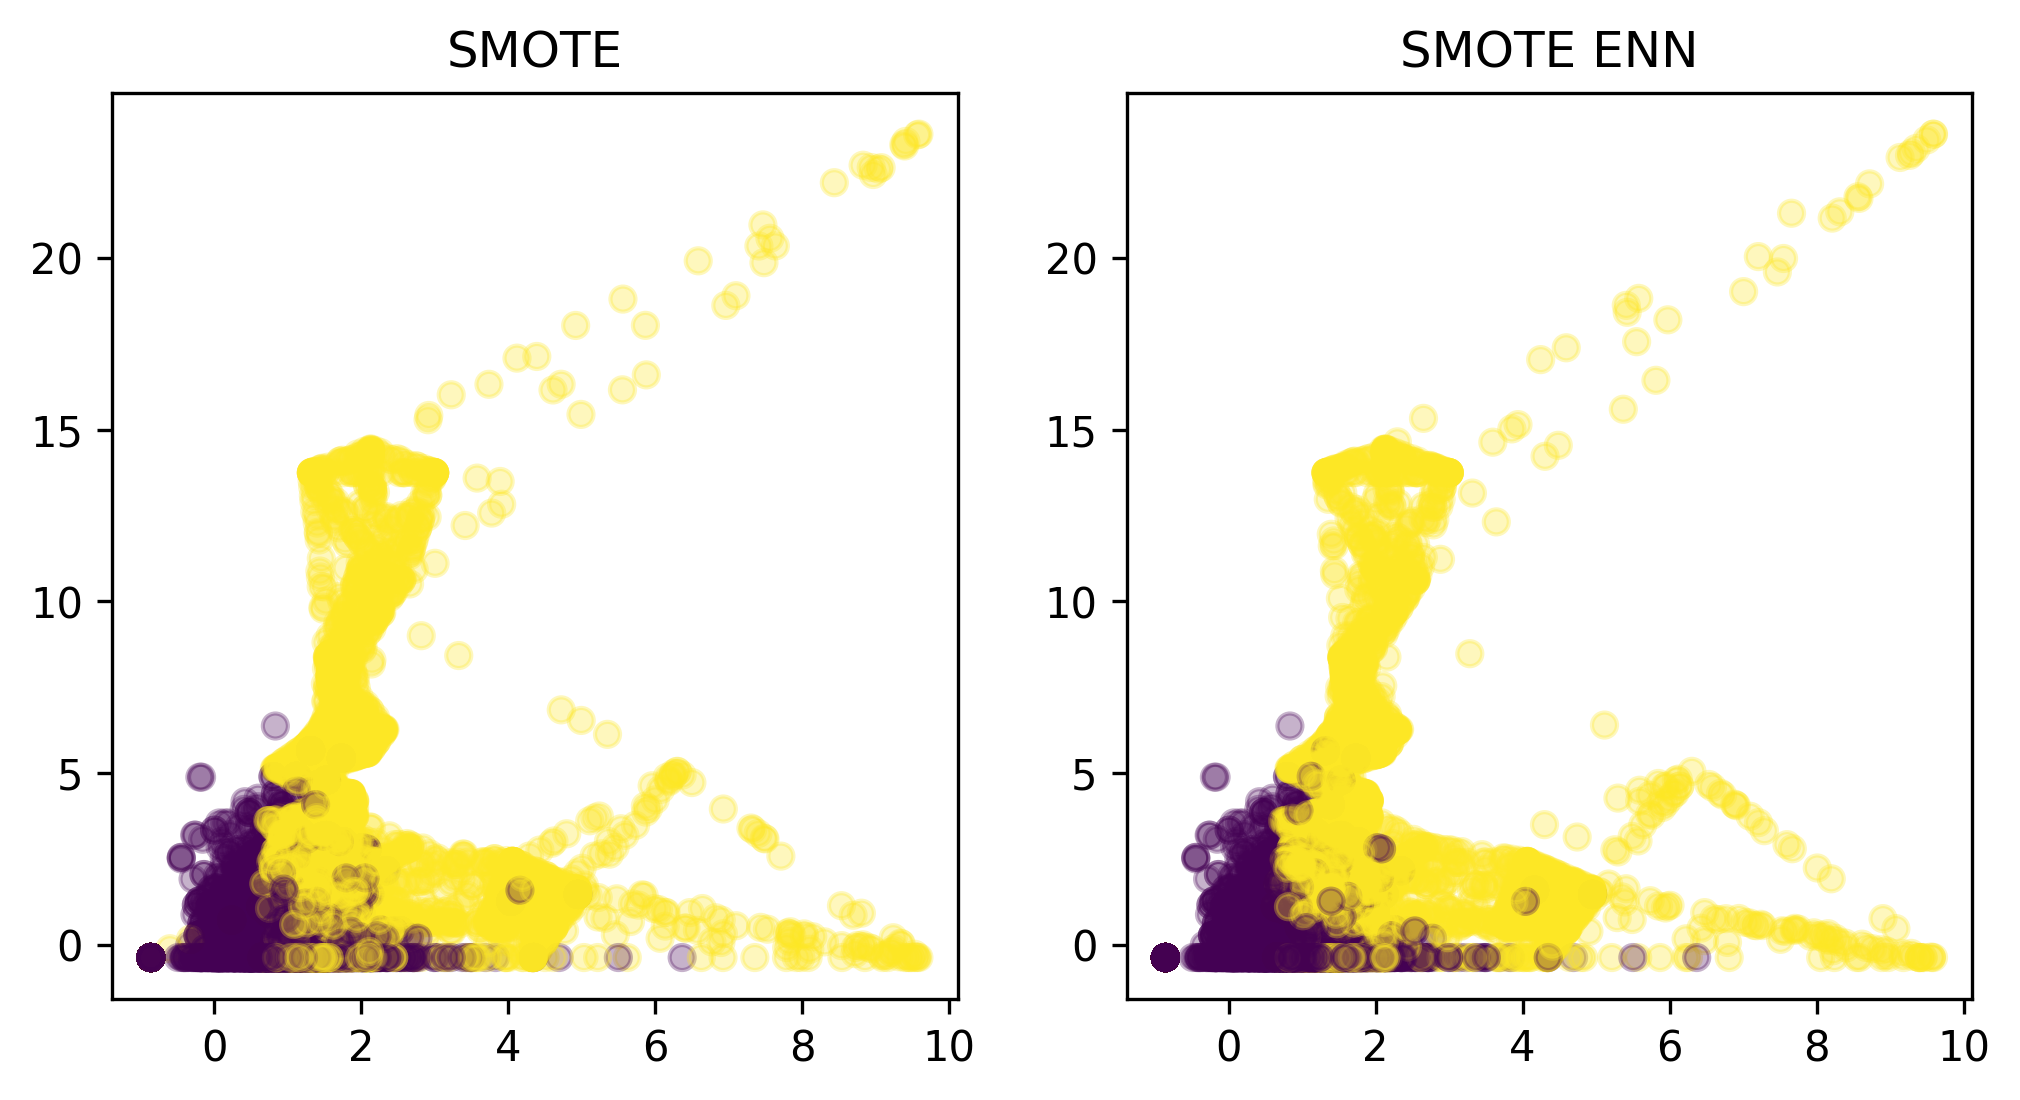

In [299]:
smoteenn = SMOTEENN(smote=SMOTE(k_neighbors=11))

X_train_smoteenn, y_train_smoteenn = smoteenn.fit_sample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_shenn, y_smote_shenn = shuffle(X_train_smoteenn, y_train_smoteenn)
axes[0].scatter(X_smote_sh11[:, 3], X_smote_sh11[:, 4], c=y_smote_sh11, alpha=.3)
axes[1].scatter(X_smote_shenn[:, 3], X_smote_shenn[:, 4], c=y_smote_shenn, alpha=.3)
axes[0].set_title("SMOTE")
axes[1].set_title("SMOTE ENN")

In [231]:
np.bincount(y_train_smote11)

array([8192, 8192])

In [230]:
np.bincount(y_train_smoteenn)

array([8192, 7755])

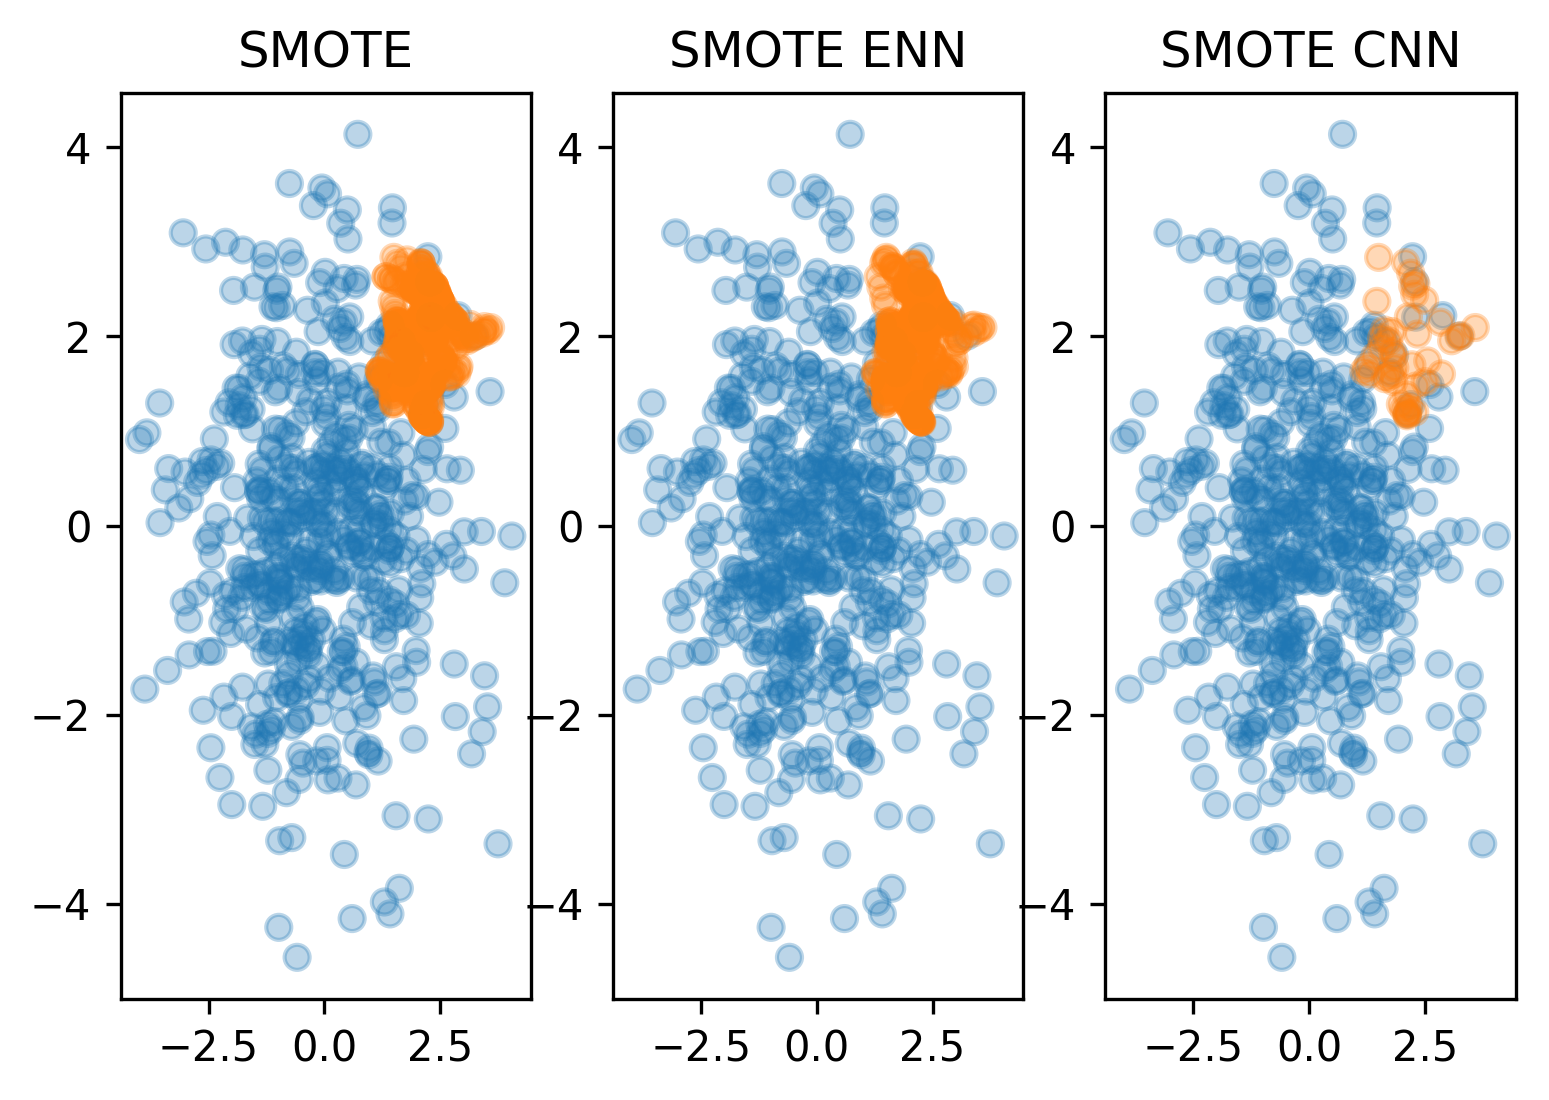

In [305]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
X_resampled_enn, y_resampled_enn = SMOTEENN().fit_sample(X_syn, y_syn)
X_resampled_cnn, y_resampled_cnn = make_imb_pipeline(SMOTE(), CondensedNearestNeighbour()).fit_sample(X_syn, y_syn)

fig, axes = plt.subplots(1, 3)

axes[0].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.Vega10(y_resampled), alpha=.3)
axes[0].set_title("SMOTE")
axes[1].scatter(X_resampled_enn[:, 0], X_resampled_enn[:, 1], c=plt.cm.Vega10(y_resampled_enn), alpha=.3)
axes[1].set_title("SMOTE ENN")
axes[2].scatter(X_resampled_cnn[:, 0], X_resampled_cnn[:, 1], c=plt.cm.Vega10(y_resampled_cnn), alpha=.3)
axes[2].set_title("SMOTE CNN")